In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = 'darkgrid')

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', 200)

from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn_extra.cluster import KMedoids

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

import warnings
warnings.filterwarnings('ignore')

In [39]:
data = pd.read_csv('Fantasy Sports Data.csv')
data.head()

,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
0,Alex Runnarsson,Arsenal,Goalkeeper,0,0,1,15,0,0.0,16.6,0,0,0
1,Alexandre Lacazette,Arsenal,Forward,13,3,129,1916,21,307.4,602.4,797,21,7
2,Bernd Leno,Arsenal,Goalkeeper,0,0,131,3131,37,0.0,702.2,2,11,11
3,Bukayo Saka,Arsenal,Midfielder,5,5,114,2554,31,650.6,493.0,984,8,8
4,Calum Chambers,Arsenal,Defender,0,3,36,751,10,169.4,171.8,77,3,2


In [40]:
data.shape

(476, 13)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player_Name     476 non-null    object 
 1   Club            476 non-null    object 
 2   Position        476 non-null    object 
 3   Goals_Scored    476 non-null    int64  
 4   Assists         476 non-null    int64  
 5   Total_Points    476 non-null    int64  
 6   Minutes         476 non-null    int64  
 7   Goals_Conceded  476 non-null    int64  
 8   Creativity      476 non-null    float64
 9   Influence       476 non-null    float64
 10  Threat          476 non-null    int64  
 11  Bonus           476 non-null    int64  
 12  Clean_Sheets    476 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 48.5+ KB


In [42]:
data.duplicated().sum()

0

# **Exploratory Data Analysis**

In [43]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Goals_Scored,476.0,1.907563,3.455562,0.0,0.00,0.50,2.00,23.0
Assists,476.0,1.752101,2.708563,0.0,0.00,0.00,2.00,14.0
Total_Points,476.0,58.516807,51.293559,0.0,10.00,48.00,94.25,244.0
Minutes,476.0,1336.909664,1073.773995,0.0,268.75,1269.50,2256.25,3420.0
Goals_Conceded,476.0,19.157563,15.946171,0.0,4.00,18.00,31.00,68.0
Creativity,476.0,195.976050,251.478541,0.0,8.30,96.95,296.95,1414.9
Influence,476.0,294.617647,267.779681,0.0,46.50,233.10,499.50,1318.2
Threat,476.0,224.962185,318.240377,0.0,5.75,104.50,298.25,1980.0
Bonus,476.0,4.718487,6.252625,0.0,0.00,2.00,7.00,40.0
Clean_Sheets,476.0,4.745798,4.394312,0.0,0.00,4.00,8.00,19.0


Goals_Scored
Skew: 2.77


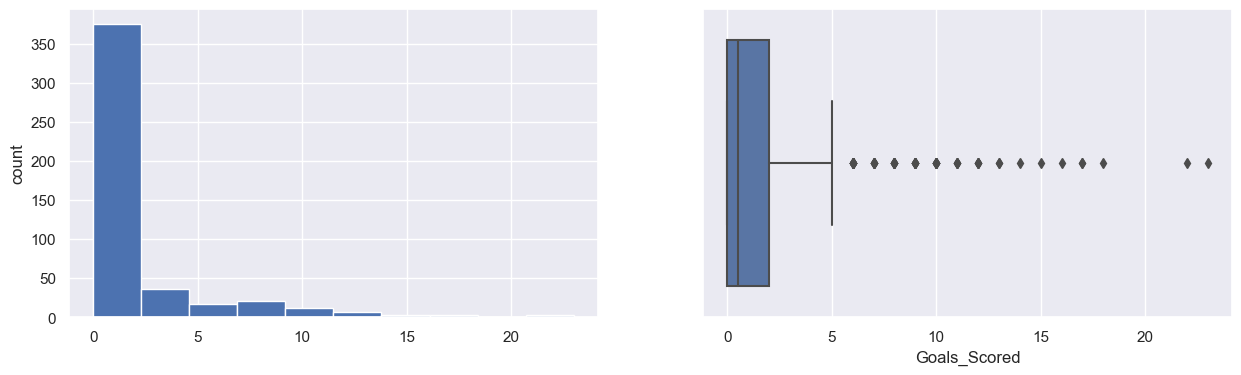

Assists
Skew: 2.06


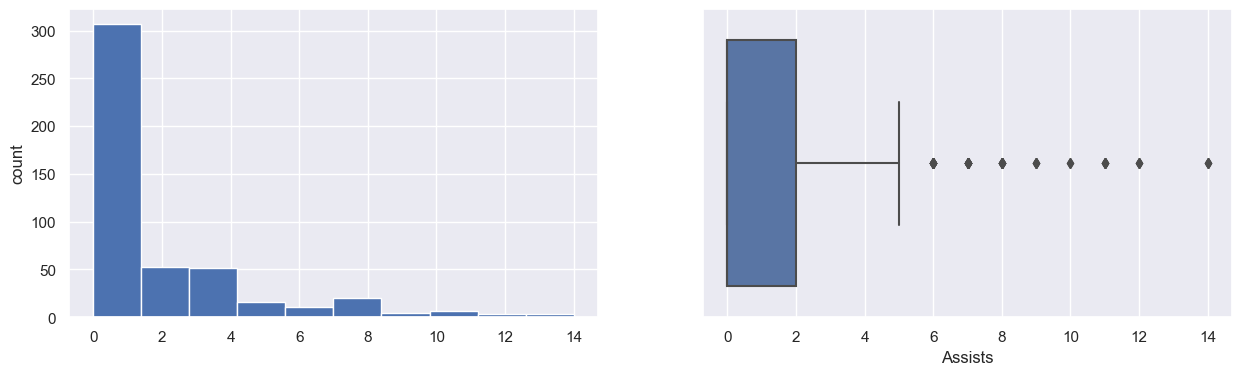

Total_Points
Skew: 0.75


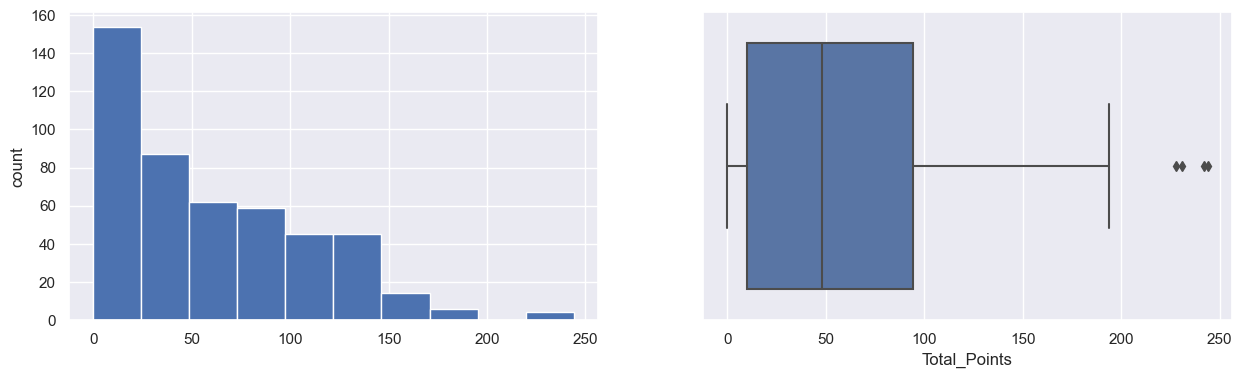

Minutes
Skew: 0.29


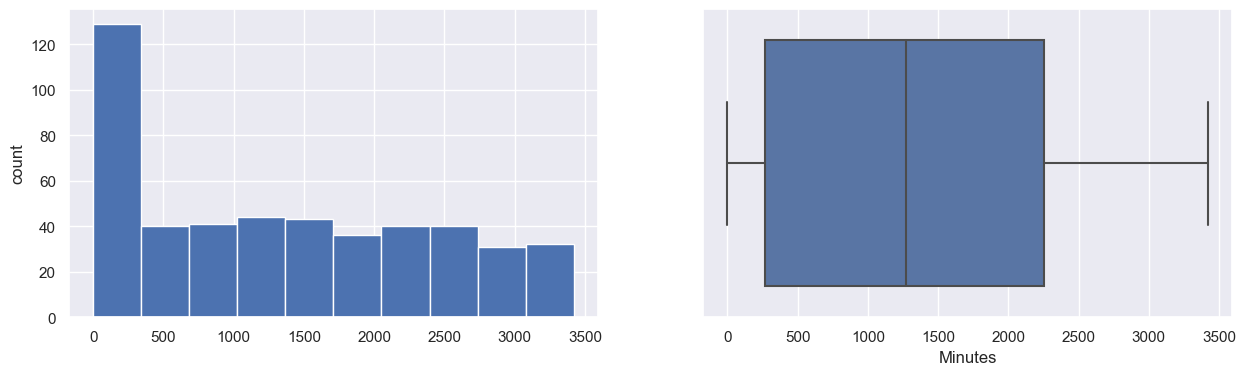

Goals_Conceded
Skew: 0.52


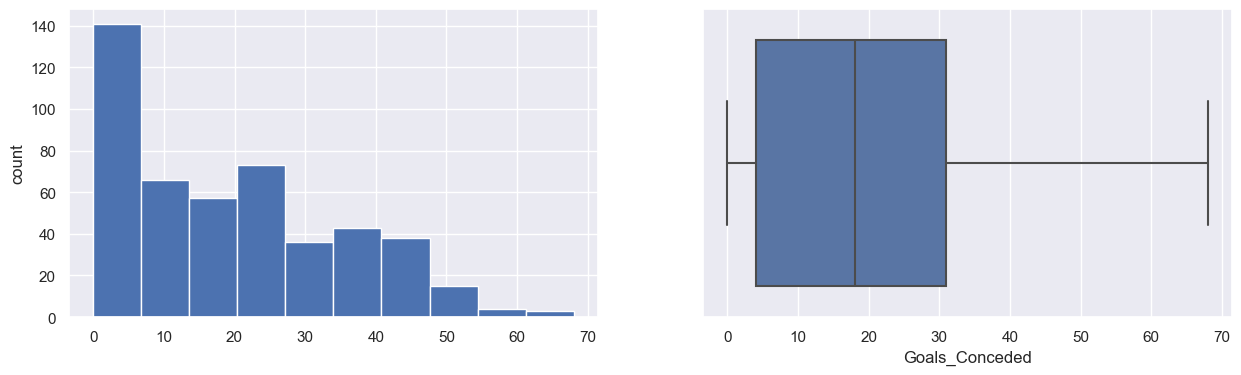

Creativity
Skew: 1.87


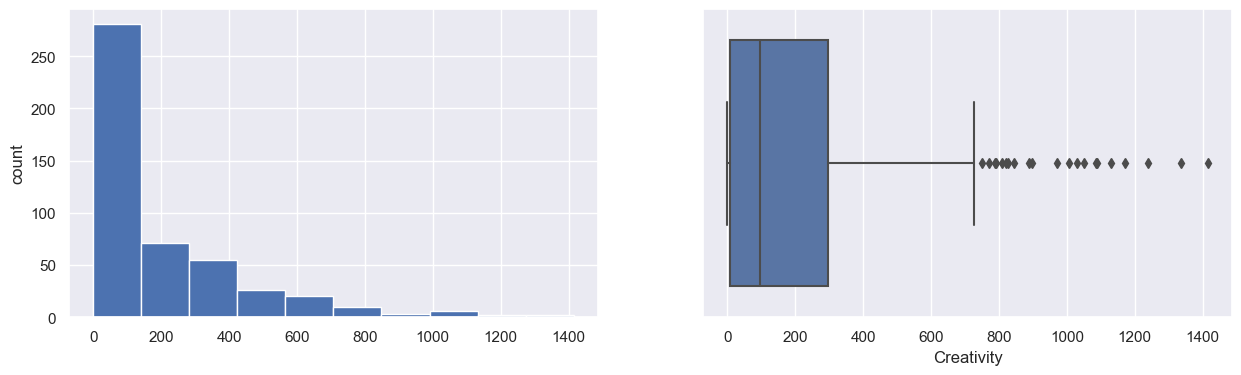

Influence
Skew: 0.76


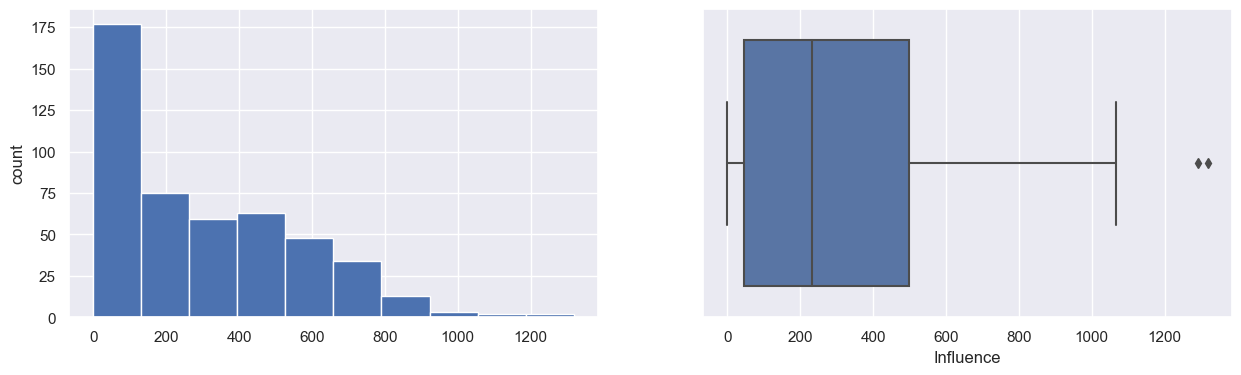

Threat
Skew: 2.27


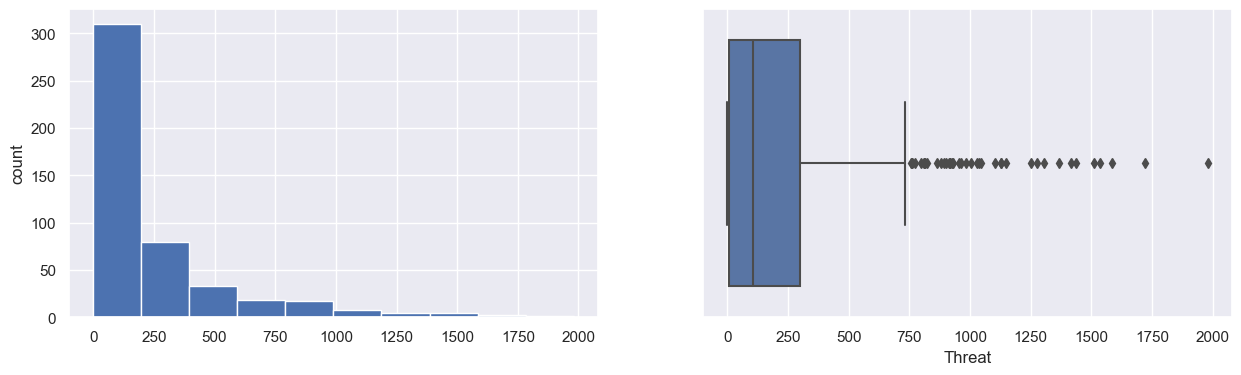

Bonus
Skew: 1.82


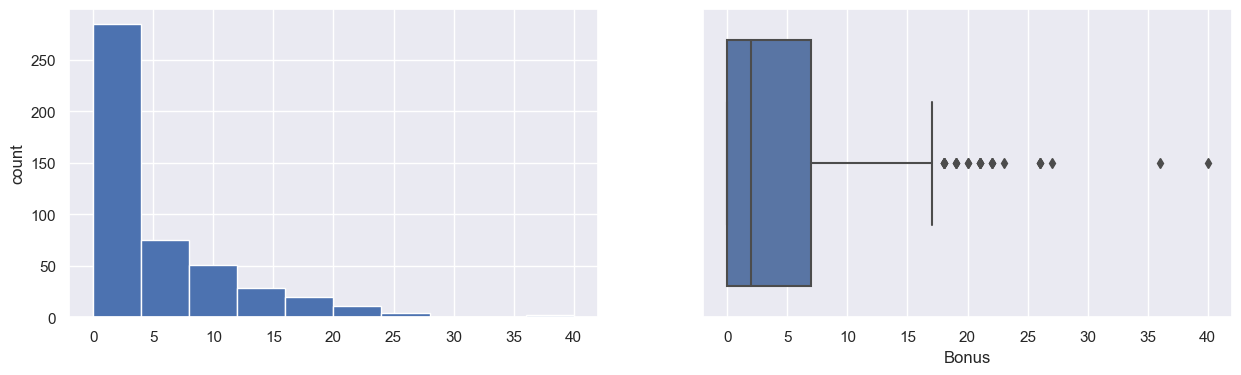

Clean_Sheets
Skew: 0.58


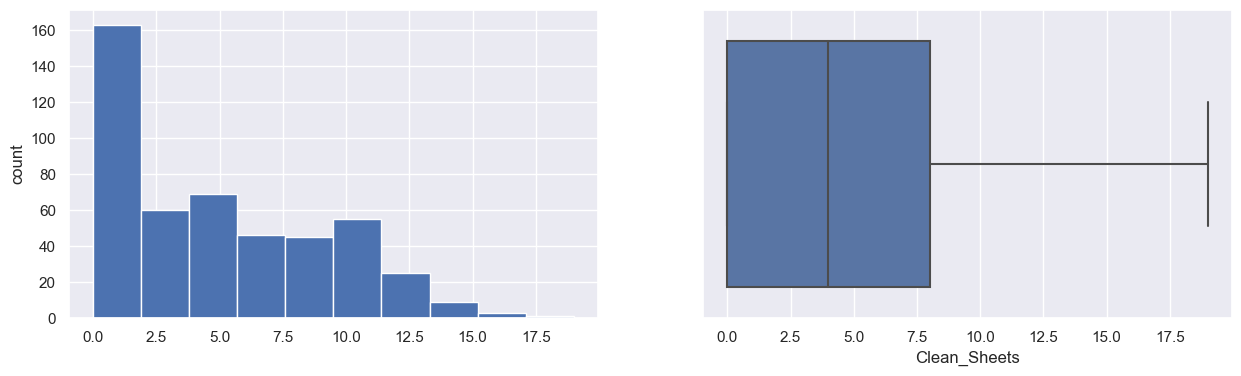

In [44]:
for col in data.columns[3:]:
    print(col)
    print('Skew:', round(data[col].skew(),2))
    
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    
    data[col].hist(bins = 10, grid = True)
    
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = data[col])
    
    plt.show()

Player_Name


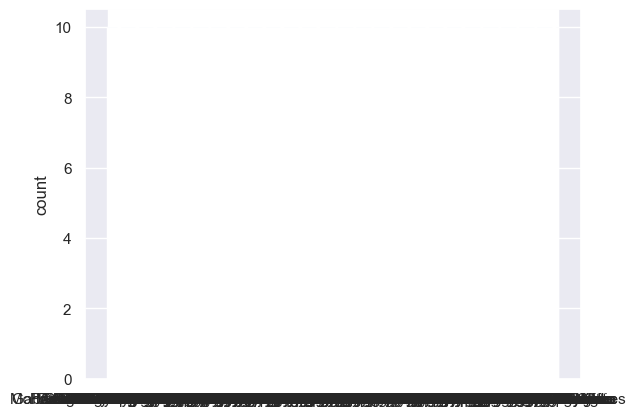

Club


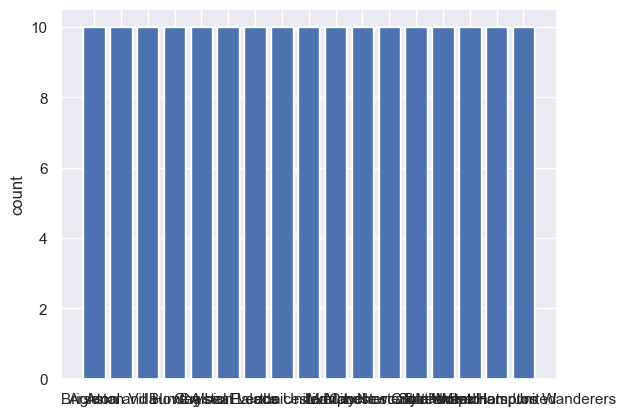

Position


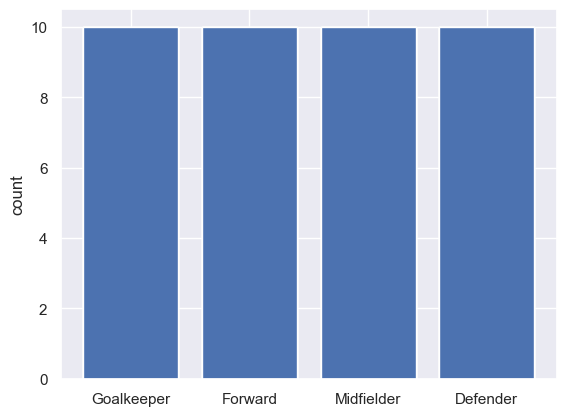

In [45]:
for col in data.columns [0:3]:
    print(col)
        
    plt.bar(x = data[col], height = 10)
    
    plt.ylabel('count')
    
    plt.show()

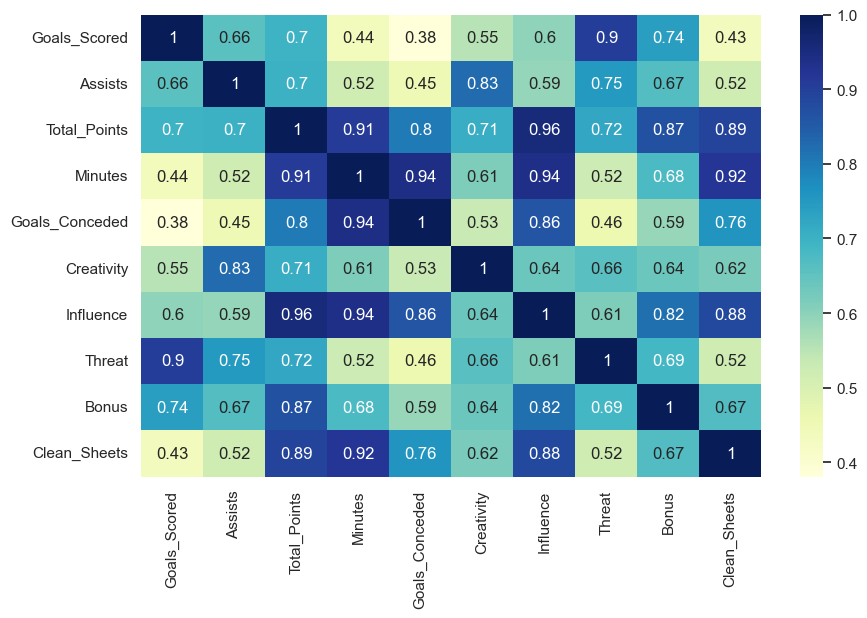

In [46]:
plt.figure(figsize = (10, 6))
sns.heatmap(data.corr(), annot = True, cmap = 'YlGnBu')
plt.show()

**Observations:**
* The highest correlation is between influence and total points. 
* Most of the strong correlations involve total minutes played. 

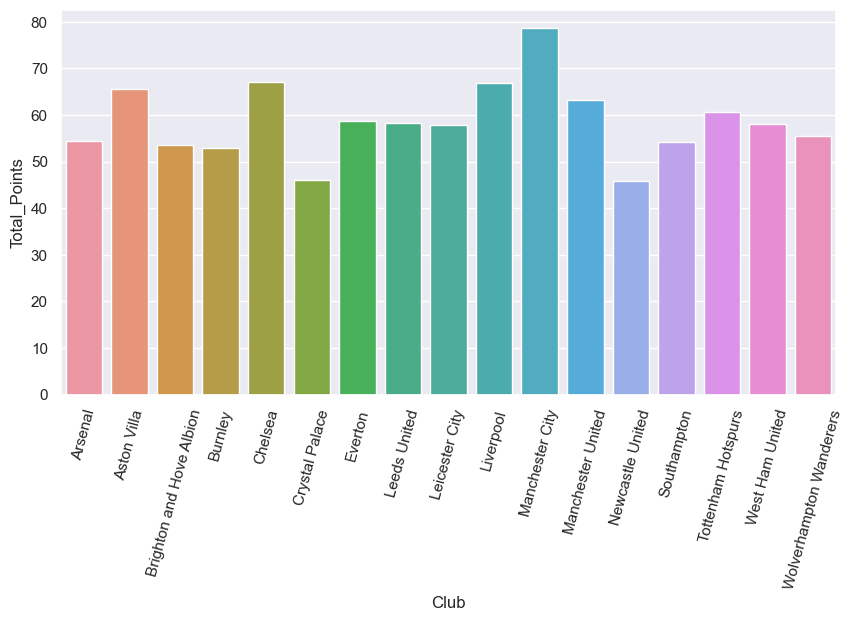

In [47]:
plt.figure(figsize = (10, 5))
sns.barplot(data = data, x = 'Club', y = 'Total_Points', ci = False)
plt.xticks(rotation = 75)
plt.show()

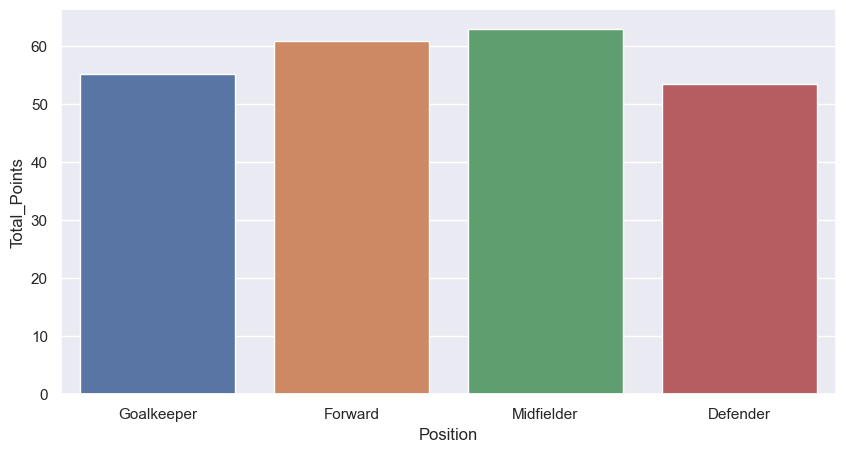

In [48]:
plt.figure(figsize = (10, 5))
sns.barplot(data = data, x = 'Position', y = 'Total_Points', ci = False)
plt.show()

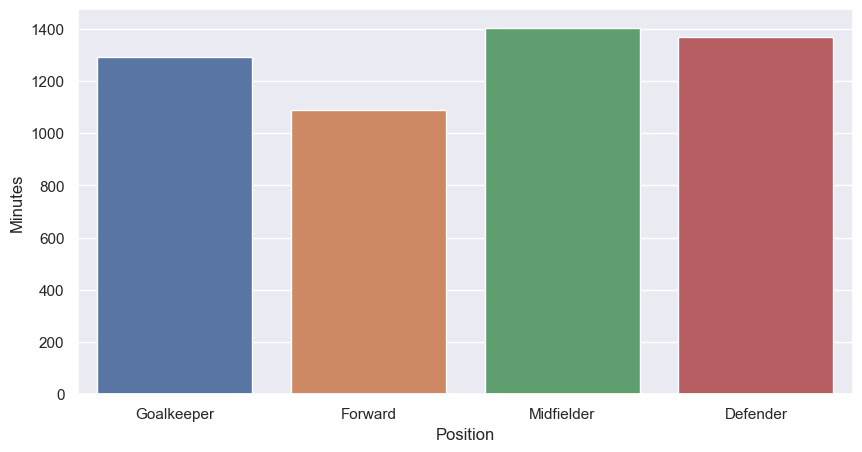

In [49]:
plt.figure(figsize = (10, 5))
sns.barplot(data = data, x = 'Position', y = 'Minutes', ci = False)
plt.show()

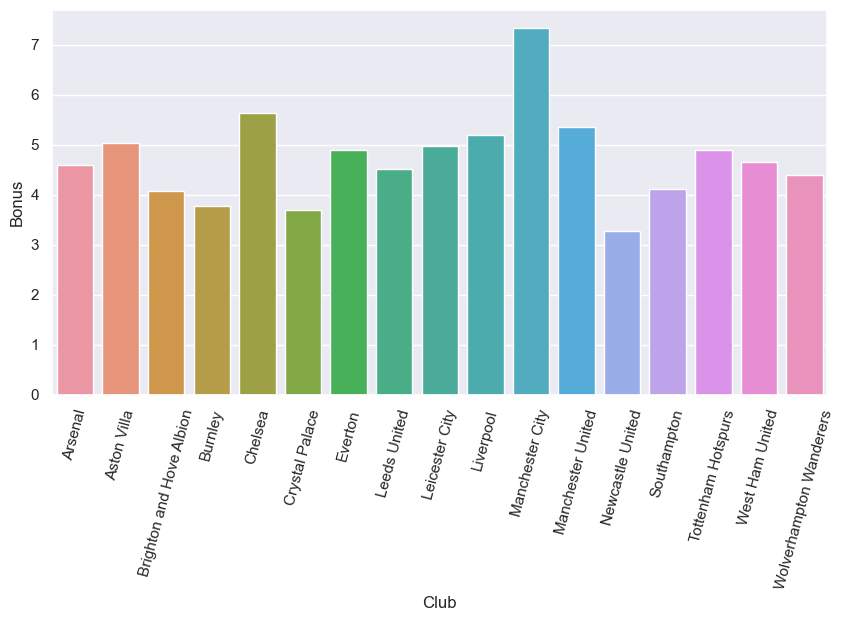

In [50]:
plt.figure(figsize = (10, 5))
sns.barplot(data = data, x = 'Club', y = 'Bonus', ci = False)
plt.xticks(rotation = 75)
plt.show()

In [51]:
pos_list = data.Position.unique().tolist()
pos_list

['Goalkeeper', 'Forward', 'Midfielder', 'Defender']

In [52]:
data_pos = pd.DataFrame()

for pos in pos_list:
    df_pos = data[data.Position == pos]
    data_pos = data_pos.append(df_pos[df_pos.Total_Points == df_pos.Total_Points.max()][['Player_Name', 'Club', 'Position', 'Total_Points']])
    
data_pos  

,Player_Name,Club,Position,Total_Points
36,Emiliano Martinez,Aston Villa,Goalkeeper,186
403,Harry Kane,Tottenham Hotspurs,Forward,242
315,Bruno Fernandes,Manchester United,Midfielder,244
223,Stuart Dallas,Leeds United,Defender,171


In [53]:
top10 = pd.DataFrame()

for pos in pos_list:
    df_pos = data[data.Position == pos]
    top10 = top10.append(df_pos.sort_values('Total_Points', ascending = False).reset_index(drop = True).loc[:10, ['Player_Name', 'Club', 'Position', 'Total_Points']])
    
top10

,Player_Name,Club,Position,Total_Points
0,Emiliano Martinez,Aston Villa,Goalkeeper,186
1,Ederson Moares,Manchester City,Goalkeeper,160
2,Illan Meslier,Leeds United,Goalkeeper,154
3,Hugo Lloris,Tottenham Hotspurs,Goalkeeper,149
4,Nick Pope,Burnley,Goalkeeper,144
5,Alisson Becker,Liverpool,Goalkeeper,140
6,Edouard Mendy,Chelsea,Goalkeeper,140
7,Lukasz Fabianski,West Ham United,Goalkeeper,133
8,Rui Pedro Patricio,Wolverhampton Wanderers,Goalkeeper,132
9,Bernd Leno,Arsenal,Goalkeeper,131


# **Scaling the Data**

In [54]:
scaler = StandardScaler()
df = data.iloc[:, 3:].copy()
scaled_data = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

scaled_data.head()

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
0,-0.552608,-0.647555,-1.122506,-1.232383,-1.202653,-0.780115,-1.039325,-0.707638,-0.755435,-1.081123
1,3.213401,0.461208,1.375560,0.539871,0.115663,0.443542,1.150596,1.799393,2.606688,0.513521
2,-0.552608,-0.647555,1.414592,1.672585,1.120094,-0.780115,1.523682,-0.701346,1.005677,1.424747
3,0.895857,1.200384,1.082818,1.134662,0.743432,1.809706,0.741621,2.387618,0.525374,0.741328
4,-0.552608,0.461208,-0.439441,-0.546229,-0.574884,-0.105790,-0.459134,-0.465428,-0.275132,-0.625510


In [55]:
from sklearn.decomposition import PCA
n = scaled_data.shape[1]

pca = PCA(n_components = n, random_state = 1)
scaled_data_pca = pd.DataFrame(pca.fit_transform(scaled_data))

exp_var = pca.explained_variance_ratio_

# K-Means Clustering

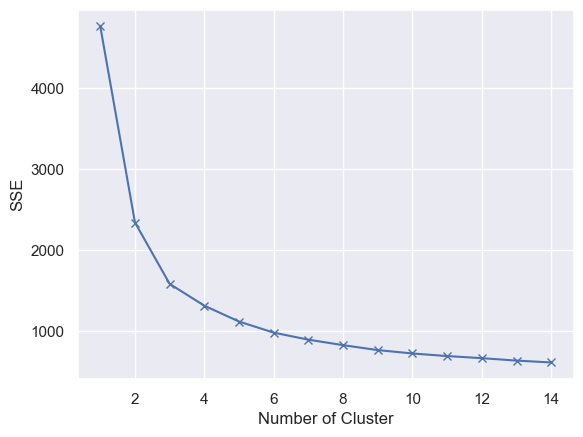

In [56]:
sse = {}

for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(scaled_data_pca)
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Cluster')
plt.ylabel('SSE')
plt.show()

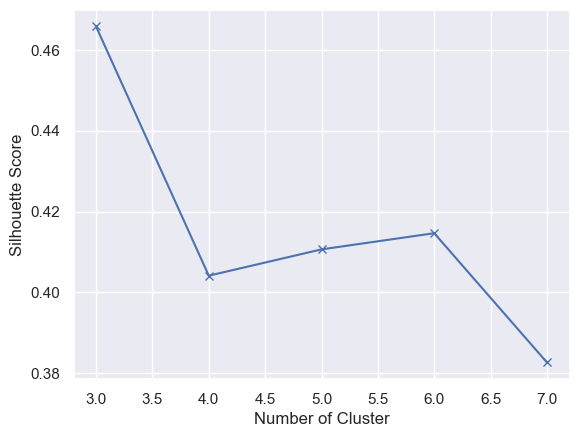

In [57]:
sc = {}

for k in range(3, 8):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(scaled_data_pca)
    labels = kmeans.predict(scaled_data_pca)
    sc[k] = silhouette_score(scaled_data_pca, labels)
    
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

In [58]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(scaled_data_pca)

scaled_data_pca['KMeans_Labels'] = kmeans.labels_
data['KMeans_Labels'] = kmeans.labels_

In [59]:
data['KMeans_Labels'].value_counts()

3    188
0    128
1     99
2     61
Name: KMeans_Labels, dtype: int64

In [60]:
kmeans_cluster_profile = data.groupby('KMeans_Labels').mean()
kmeans_cluster_profile['Players_in_Cluster'] = (data.groupby('KMeans_Labels')['Total_Points'].count().values)
kmeans_cluster_profile

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,Players_in_Cluster
KMeans_Labels,,,,,,,,,,,
0,1.460938,1.601562,55.648438,1389.453125,20.554688,187.653125,270.037500,218.117188,3.312500,4.687500,128
1,1.363636,1.878788,103.525253,2670.555556,37.525253,265.671717,579.185859,199.636364,7.676768,10.020202,99
2,9.147541,6.639344,141.557377,2446.704918,33.344262,617.495082,659.324590,880.540984,16.147541,9.213115,61
3,0.148936,0.202128,9.824468,238.750000,3.930851,28.171809,43.164894,30.244681,0.409574,0.558511,188


In [61]:
kmeans_cluster_profile.style.highlight_max(color = 'lightblue', axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,Players_in_Cluster
KMeans_Labels,,,,,,,,,,,
0,1.460938,1.601562,55.648438,1389.453125,20.554688,187.653125,270.037500,218.117188,3.312500,4.687500,128
1,1.363636,1.878788,103.525253,2670.555556,37.525253,265.671717,579.185859,199.636364,7.676768,10.020202,99
2,9.147541,6.639344,141.557377,2446.704918,33.344262,617.495082,659.324590,880.540984,16.147541,9.213115,61
3,0.148936,0.202128,9.824468,238.750000,3.930851,28.171809,43.164894,30.244681,0.409574,0.558511,188


In [62]:
for players in data['KMeans_Labels'].unique():
    print('Players present in Cluster {}:'.format(players))
    print(data[data['KMeans_Labels'] == players]['Player_Name'].unique())
    print()

Players present in Cluster 3:
['Alex Runnarsson' 'Cedric Soares' 'Edward Nketiah'
 'Gabriel Teodoro Martinelli Silva' 'Matt Macey' 'Miguel Azeez'
 'Pablo Mari' 'Reiss Nelson' 'Sead Kolasinac' 'Shkodran Mustafi'
 'Sokratis Papastathopoulos' 'William Saliba' 'Ahmed El Mohamady'
 'Carney Chukwuemeka' 'Conor Hourihane' 'Henri Lansbury' 'Jacob Ramsey'
 'Jaden Philogene-Bidace' 'Jose Peleteiro Romallo' 'Keinan Davis'
 'Kortney Hause' 'Marvelous Nakamba' 'Morgan Sanson' 'Orjan Nyland'
 'Wesley Moraes' 'Alireza Jahanbakhsh' 'Andi Zeqiri'
 'Bernardo Fernandes da Silva Junior' 'Davy Propper' 'Jakub Moder'
 'Jason Steele' 'Jayson Molumby' 'Jose Izquierdo' 'Percy Tau'
 'Reda Khadra' 'Anthony Driscoll-Glennon' 'Bailey Peacock-Farrell'
 'Dale Stephens' 'Jimmy Dunne' 'Joel Mumbongo' 'Josh Benson' 'Kevin Long'
 'Lewis Richardson' 'Phil Bardsley' 'Will Norris' 'Billy Gilmour'
 'Emerson Palmieri dos Santos' 'Faustino Anjorin' 'Fikayo Tomori'
 'Karlo Ziger' 'Kepa Arrizabalaga' 'Valentino Livramento'
 'Wi

In [63]:
data.groupby(['KMeans_Labels', 'Position'])['Club'].count()

KMeans_Labels  Position  
0              Defender      47
               Forward       16
               Goalkeeper     3
               Midfielder    62
1              Defender      50
               Goalkeeper    17
               Midfielder    32
2              Defender       5
               Forward       20
               Midfielder    36
3              Defender      70
               Forward       28
               Goalkeeper    25
               Midfielder    65
Name: Club, dtype: int64

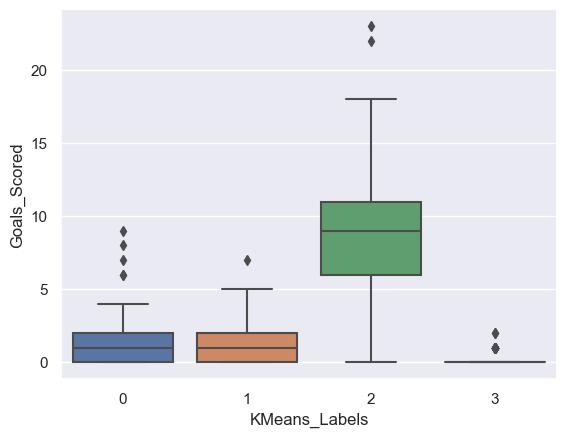

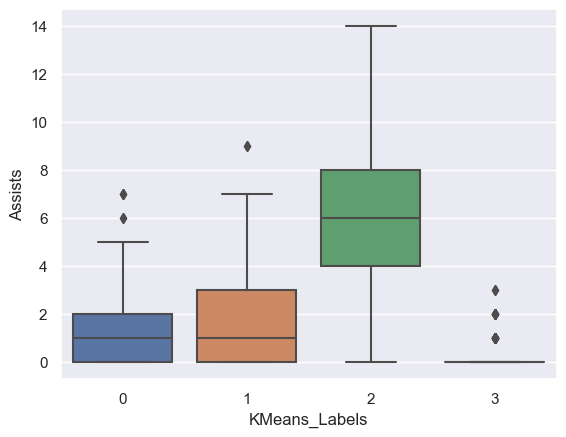

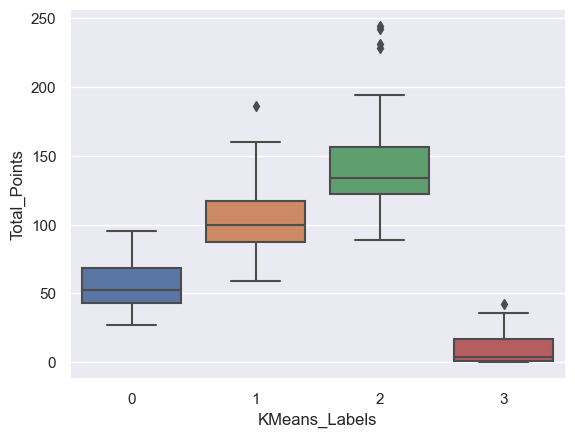

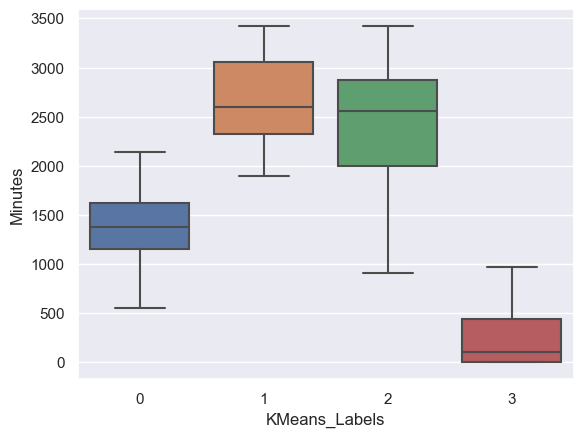

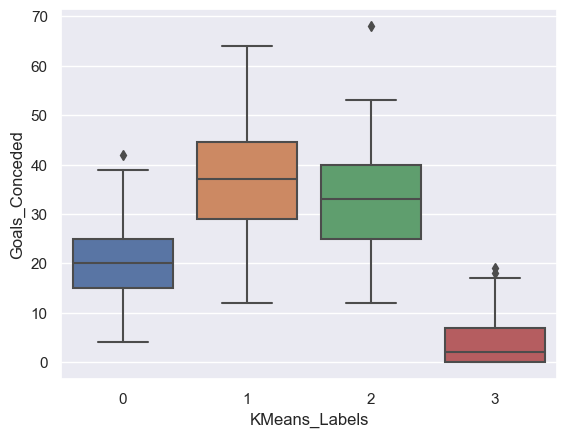

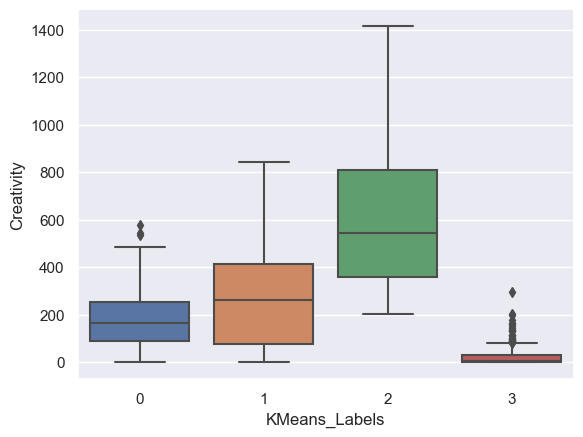

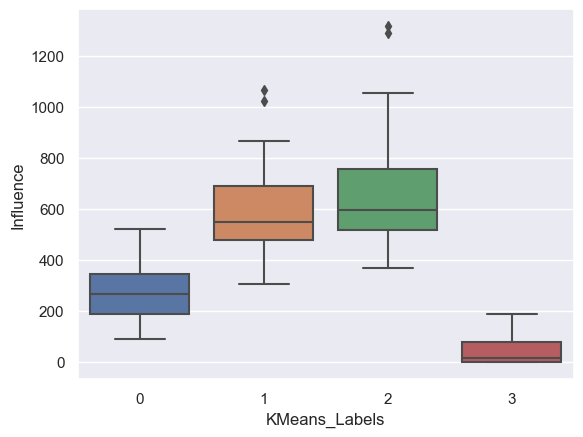

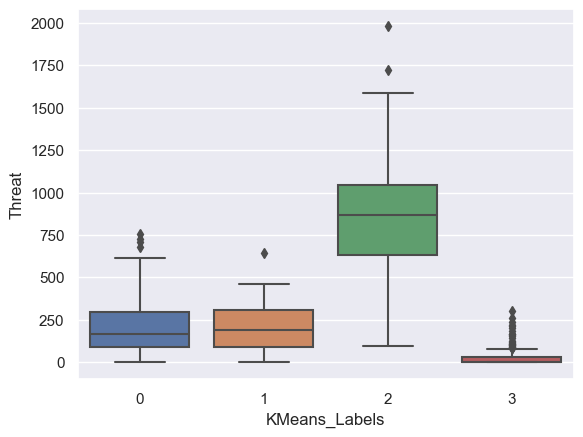

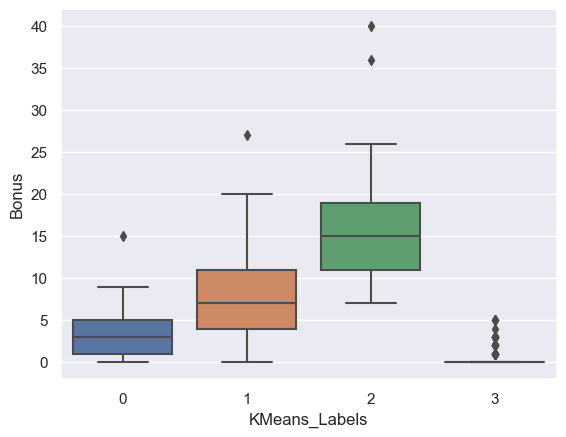

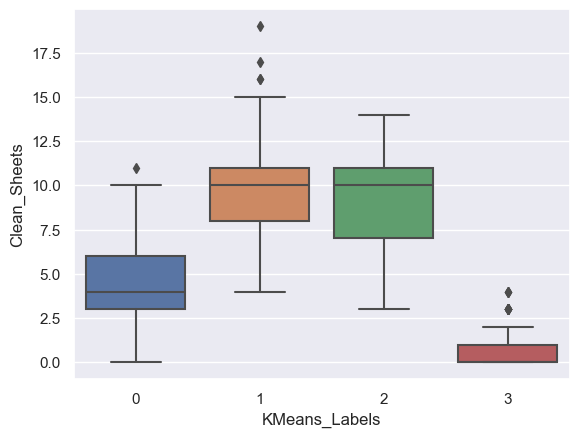

In [64]:
box_cols = ['Goals_Scored','Assists','Total_Points','Minutes','Goals_Conceded','Creativity','Influence','Threat','Bonus','Clean_Sheets']

for col in box_cols:
    sns.boxplot(x = 'KMeans_Labels', y = col, data = data)
    plt.show()

# K-Medoids Clustering

In [65]:
kmed = KMedoids(n_clusters = 4, random_state = 1)
kmed.fit(scaled_data)
scaled_data['KMed_Labels'] = kmed.labels_
data['KMed_Labels'] = kmed.labels_

In [66]:
data['KMed_Labels'].value_counts()

3    171
2    136
1     87
0     82
Name: KMed_Labels, dtype: int64

In [67]:
kmed_cluster_profile = data.groupby('KMed_Labels').mean()
kmed_cluster_profile['Players_in_Cluster'] = (data.groupby('KMed_Labels')['Total_Points'].count().values)
kmed_cluster_profile

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,Players_in_Cluster
KMed_Labels,,,,,,,,,,,,
0,7.512195,6.195122,133.243902,2452.243902,33.853659,602.902439,625.653659,745.402439,14.573171,9.231707,1.719512,82
1,1.068966,1.091954,99.528736,2638.195402,36.632184,184.582759,575.818391,166.333333,6.988506,9.931034,0.919540,87
2,1.338235,1.558824,51.073529,1270.051471,18.977941,180.458824,242.588235,203.102941,2.904412,4.205882,0.375000,136
3,0.099415,0.111111,7.736842,193.187135,3.362573,18.979532,34.188304,22.608187,0.280702,0.385965,3.000000,171


In [68]:
kmed_cluster_profile.style.highlight_max(color = 'lightpink', axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,Players_in_Cluster
KMed_Labels,,,,,,,,,,,,
0,7.512195,6.195122,133.243902,2452.243902,33.853659,602.902439,625.653659,745.402439,14.573171,9.231707,1.719512,82
1,1.068966,1.091954,99.528736,2638.195402,36.632184,184.582759,575.818391,166.333333,6.988506,9.931034,0.919540,87
2,1.338235,1.558824,51.073529,1270.051471,18.977941,180.458824,242.588235,203.102941,2.904412,4.205882,0.375000,136
3,0.099415,0.111111,7.736842,193.187135,3.362573,18.979532,34.188304,22.608187,0.280702,0.385965,3.000000,171


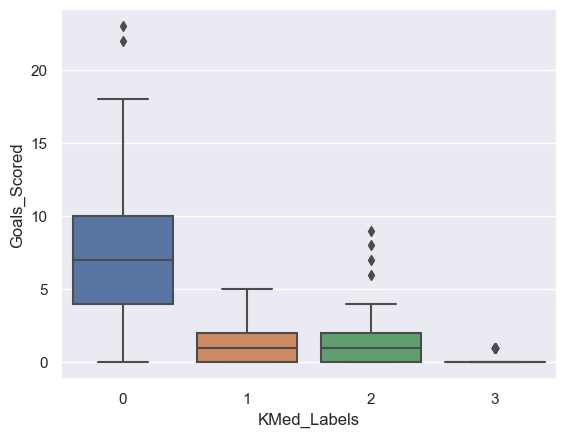

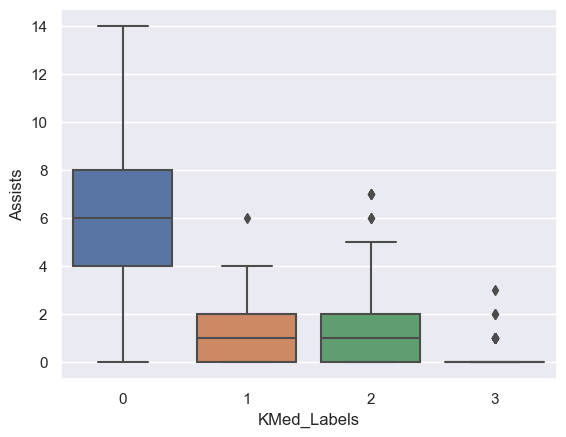

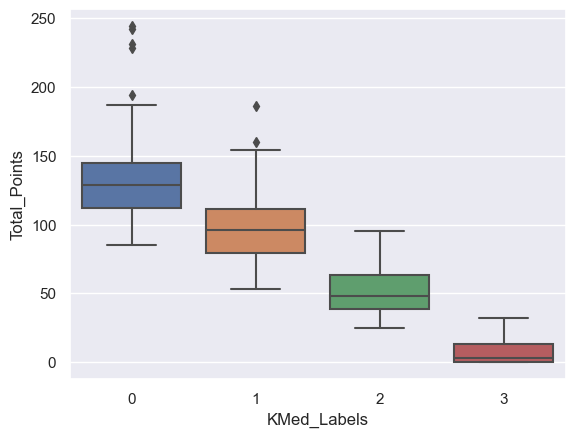

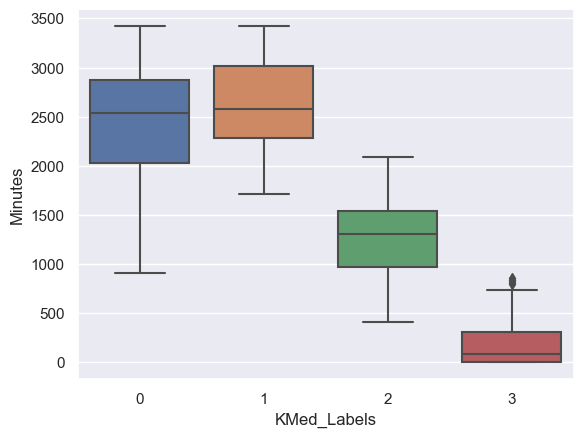

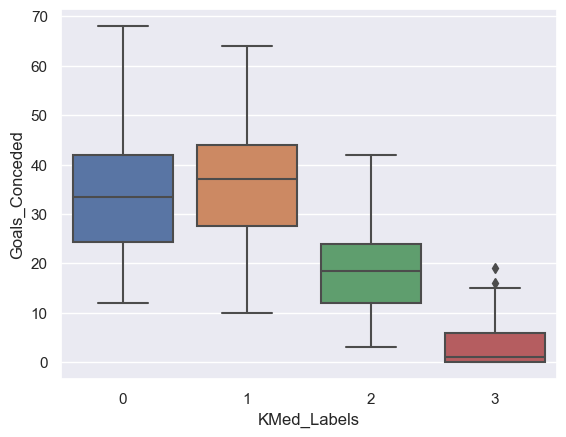

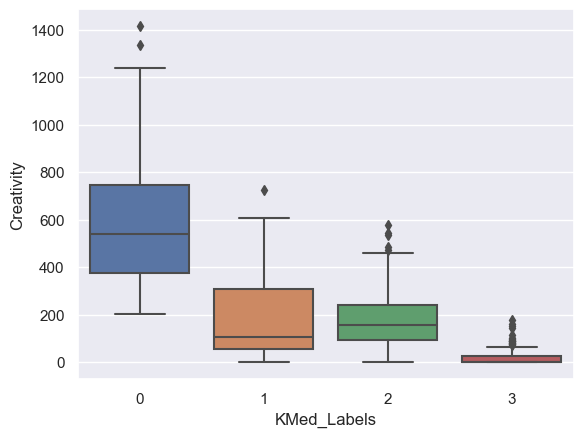

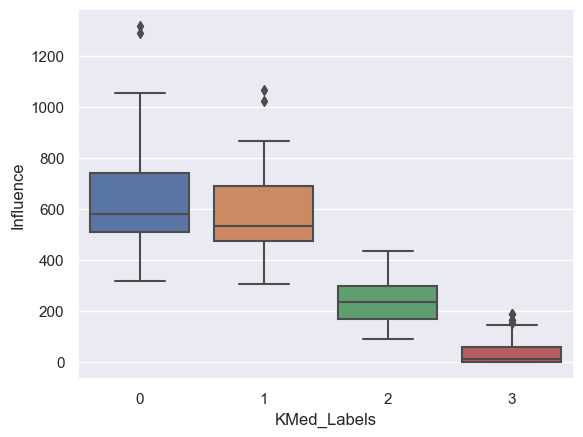

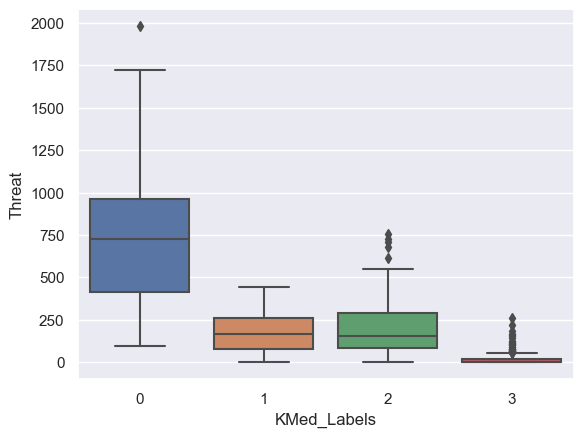

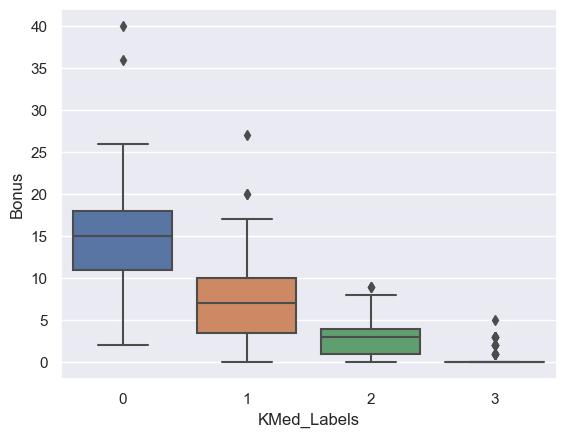

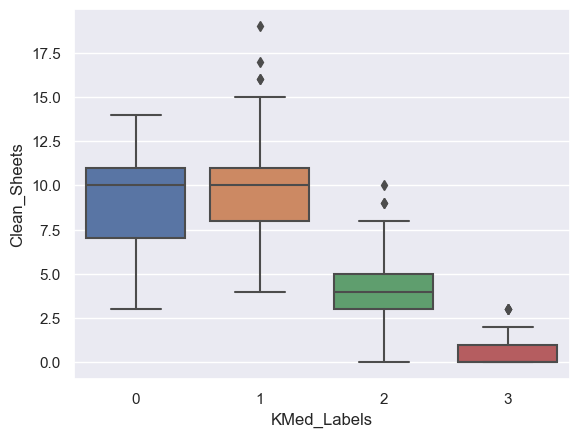

In [69]:
box_cols = ['Goals_Scored','Assists','Total_Points','Minutes','Goals_Conceded','Creativity','Influence','Threat','Bonus','Clean_Sheets']

for col in box_cols:
    sns.boxplot(x = 'KMed_Labels', y = col, data = data)
    plt.show()

# Gaussian Mixture Model

In [72]:
gmm = GaussianMixture(n_components = 3, random_state = 1)
gmm.fit(scaled_data)
scaled_data['GMMLabels'] = gmm.predict(scaled_data)
data['GMMLabels'] = gmm.predict(scaled_data)

In [73]:
data.GMMLabels.value_counts()

0    248
1    146
2     82
Name: GMMLabels, dtype: int64

In [74]:
gmm_profile = data.groupby('GMMLabels').mean()
gmm_profile['Players_in_Cluster'] = (data.groupby('GMMLabels')['Total_Points'].count().values)
gmm_profile

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,Players_in_Cluster
GMMLabels,,,,,,,,,,,,,
0,1.153226,1.314516,65.100806,1667.568548,24.044355,171.141935,343.944355,178.544355,4.125000,5.866935,0.830645,1.75,248
1,0.041096,0.000000,5.363014,148.821918,2.602740,9.612329,24.905479,11.506849,0.191781,0.321918,3.000000,3.00,146
2,7.512195,6.195122,133.243902,2452.243902,33.853659,602.902439,625.653659,745.402439,14.573171,9.231707,1.719512,0.00,82


In [75]:
gmm_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,Players_in_Cluster
GMMLabels,,,,,,,,,,,,,
0,1.153226,1.314516,65.100806,1667.568548,24.044355,171.141935,343.944355,178.544355,4.125000,5.866935,0.830645,1.750000,248
1,0.041096,0.000000,5.363014,148.821918,2.602740,9.612329,24.905479,11.506849,0.191781,0.321918,3.000000,3.000000,146
2,7.512195,6.195122,133.243902,2452.243902,33.853659,602.902439,625.653659,745.402439,14.573171,9.231707,1.719512,0.000000,82


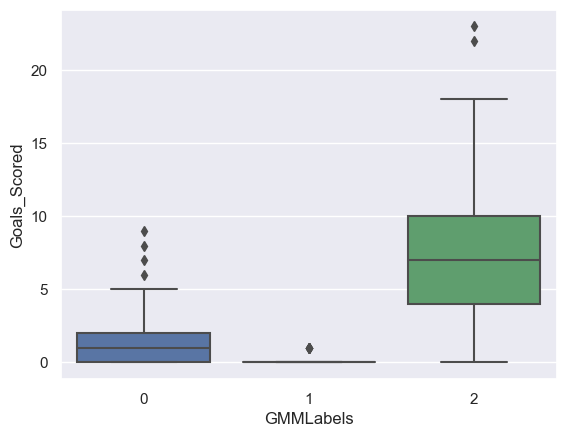

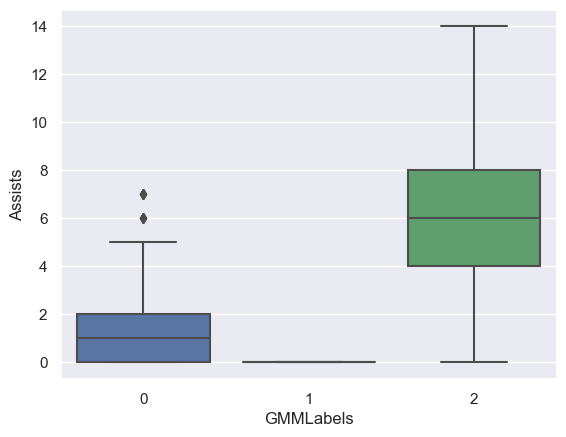

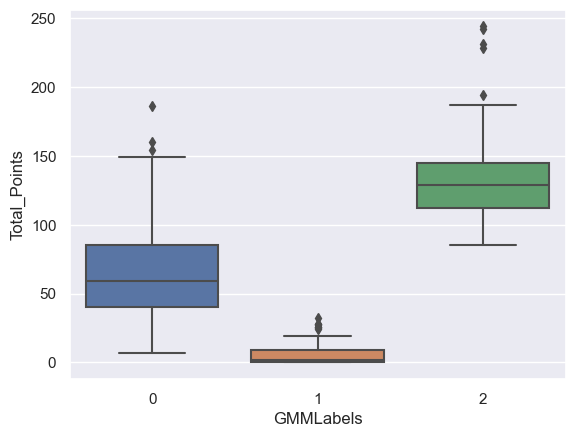

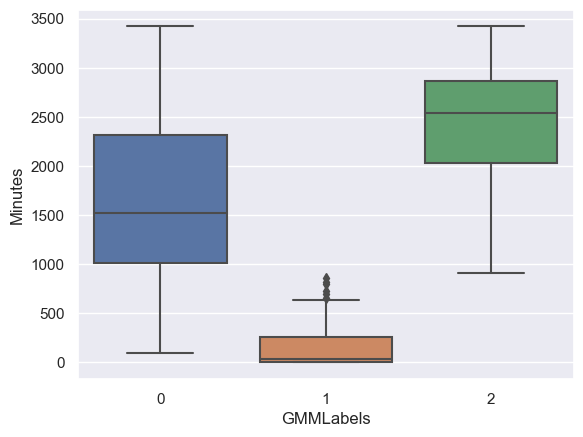

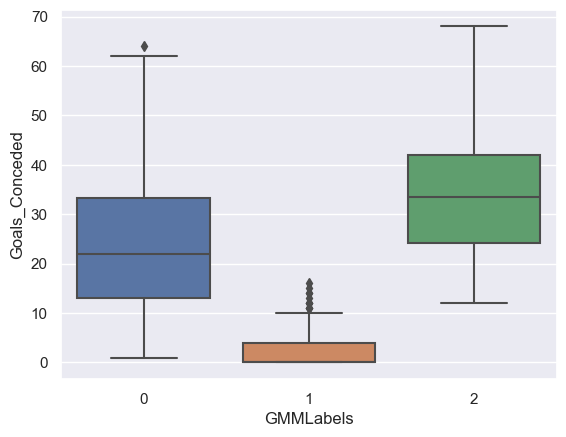

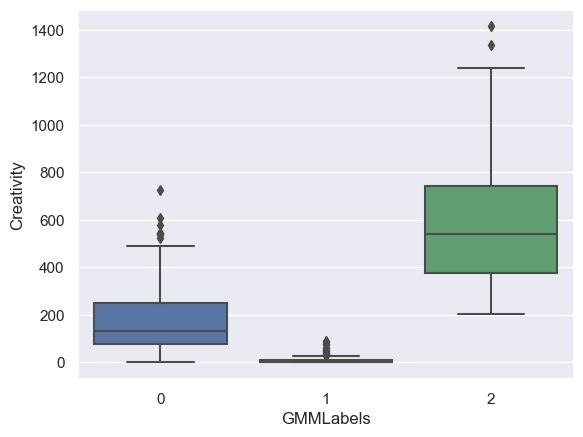

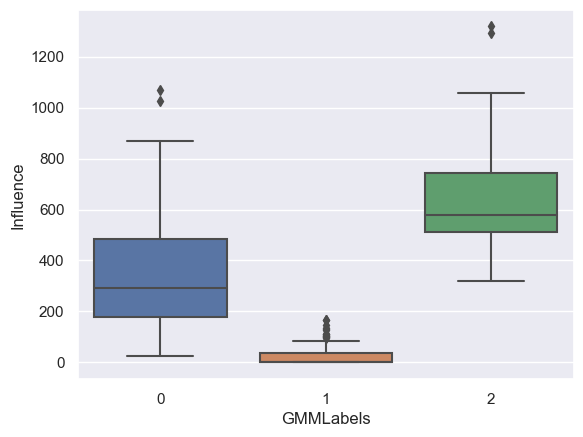

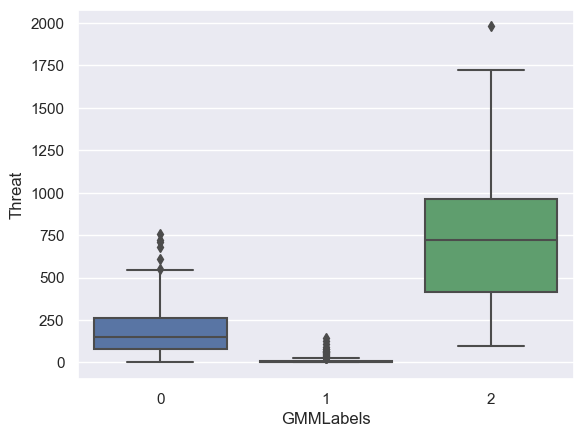

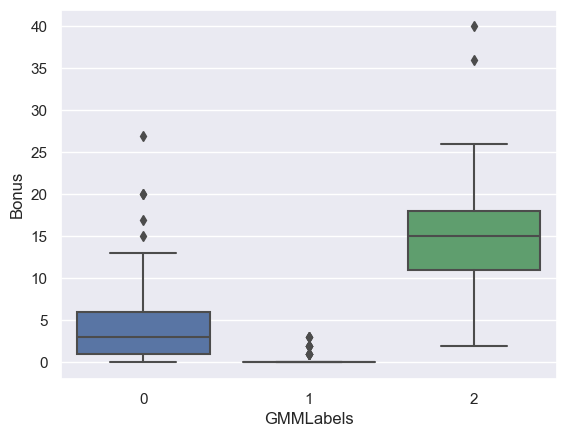

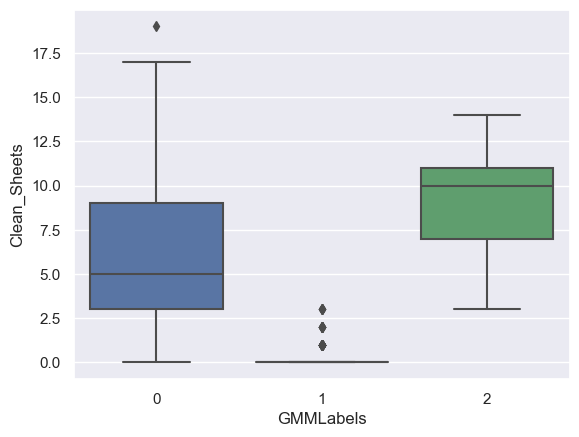

In [76]:
box_cols = ['Goals_Scored','Assists','Total_Points','Minutes','Goals_Conceded','Creativity','Influence','Threat','Bonus','Clean_Sheets']

for col in box_cols:
    sns.boxplot(x = 'GMMLabels', y = col, data = data)
    plt.show()

# Hierarchial Clustering

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage

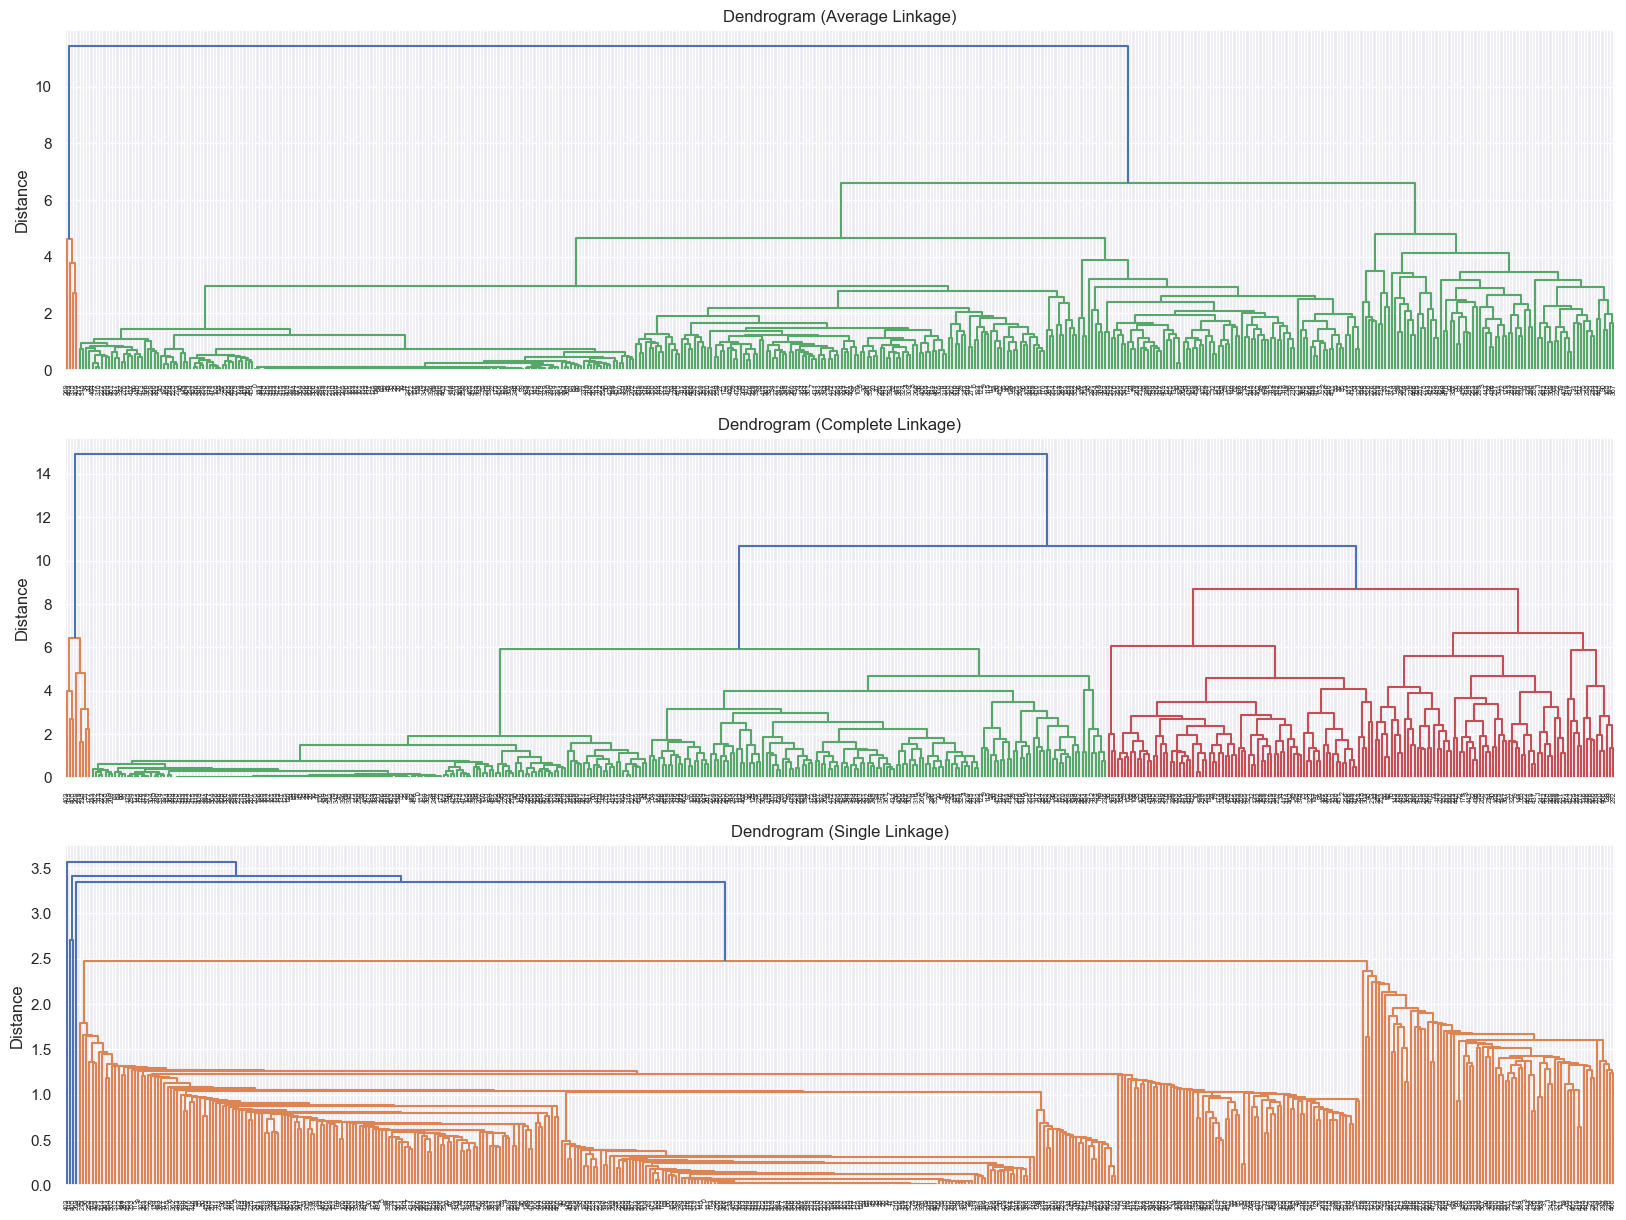

In [80]:
methods = {'single', 'average', 'complete'}

fig, axs = plt.subplots(len(methods), 1, figsize = (20, 15))

for i, method in enumerate(methods):
    z = linkage(scaled_data, metric = 'euclidean', method = method)
    dendrogram(z, ax = axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    axs[i].set_ylabel('Distance')

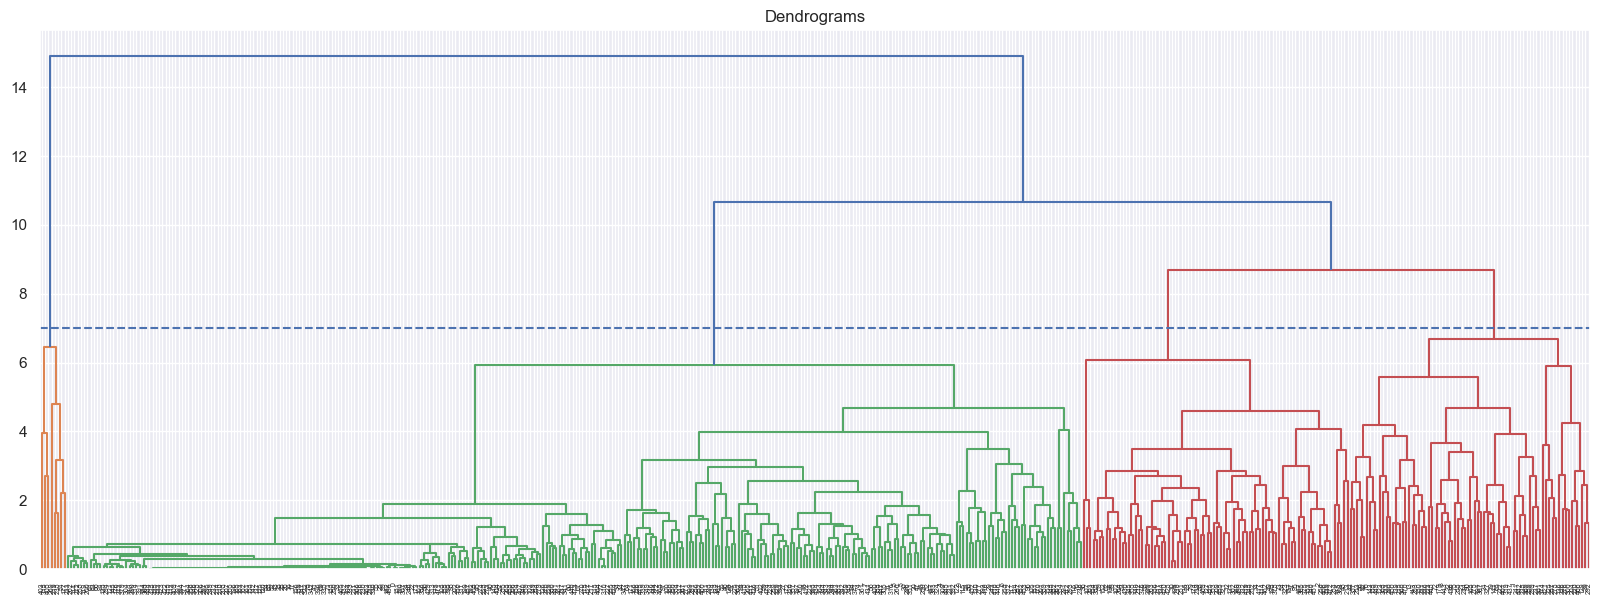

In [81]:
plt.figure(figsize = (20, 7))
plt.title('Dendrograms')
den = dendrogram(linkage(scaled_data, method = 'complete'))
plt.axhline(y = 7, color = 'b', linestyle = '--')

In [82]:
hierarchial = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')

hierarchial.fit(scaled_data)

AgglomerativeClustering(linkage='complete', n_clusters=4)

In [83]:
scaled_data['Hier_Cluster_Labels'] = hierarchial.labels_
data['Hier_Cluster_Labels'] = hierarchial.labels_

In [84]:
data.Hier_Cluster_Labels.value_counts()

2    312
3     82
0     74
1      8
Name: Hier_Cluster_Labels, dtype: int64

In [85]:
data[data.Hier_Cluster_Labels == 1]

,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,GMMLabels,Hier_Cluster_Labels
51,Ollie Watkins,Aston Villa,Forward,14,9,168,3328,46,610.4,815.4,1721,18,14,2,0,2,1
177,Dominic Calvert-Lewin,Everton,Forward,16,6,165,2871,39,308.0,745.8,1439,21,11,2,0,2,1
219,Patrick Bamford,Leeds United,Forward,17,11,194,3052,50,371.0,867.2,1512,26,10,2,0,2,1
238,Jamie Vardy,Leicester City,Forward,15,14,187,2838,44,356.6,819.2,1306,23,8,2,0,2,1
269,Mohamed Salah,Liverpool,Midfielder,22,6,231,3077,41,825.7,1056.0,1980,21,11,2,0,2,1
315,Bruno Fernandes,Manchester United,Midfielder,18,14,244,3101,36,1414.9,1292.6,1253,36,13,2,0,2,1
403,Harry Kane,Tottenham Hotspurs,Forward,23,14,242,3083,39,659.1,1318.2,1585,40,12,2,0,2,1
405,Heung-Min Son,Tottenham Hotspurs,Midfielder,17,11,228,3119,36,1049.9,1052.2,1046,26,13,2,0,2,1


In [86]:
hierarchial = data.groupby('Hier_Cluster_Labels').mean()
hierarchial['Players_in_Cluster'] = (data.groupby('Hier_Cluster_Labels')['Total_Points'].count().values)
hierarchial

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,GMMLabels,Players_in_Cluster
Hier_Cluster_Labels,,,,,,,,,,,,,,
0,6.405405,5.716216,125.229730,2386.689189,33.040541,592.464865,585.635135,665.959459,13.297297,8.986486,1.689189,0.000000,2.000000,74
1,17.750000,10.625000,207.375000,3058.625000,41.375000,699.450000,995.825000,1480.250000,26.375000,11.500000,2.000000,0.000000,2.000000,8
2,0.660256,0.759615,28.256410,692.182692,10.400641,93.564744,131.680128,103.455128,1.608974,2.230769,1.820513,2.528846,0.467949,312
3,1.048780,1.085366,98.926829,2674.682927,37.780488,178.712195,583.539024,166.841463,6.695122,9.829268,0.926829,1.012195,0.000000,82


In [89]:
hierarchial.style.highlight_max(color = 'lightyellow', axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,GMMLabels,Players_in_Cluster
Hier_Cluster_Labels,,,,,,,,,,,,,,
0,6.405405,5.716216,125.229730,2386.689189,33.040541,592.464865,585.635135,665.959459,13.297297,8.986486,1.689189,0.000000,2.000000,74
1,17.750000,10.625000,207.375000,3058.625000,41.375000,699.450000,995.825000,1480.250000,26.375000,11.500000,2.000000,0.000000,2.000000,8
2,0.660256,0.759615,28.256410,692.182692,10.400641,93.564744,131.680128,103.455128,1.608974,2.230769,1.820513,2.528846,0.467949,312
3,1.048780,1.085366,98.926829,2674.682927,37.780488,178.712195,583.539024,166.841463,6.695122,9.829268,0.926829,1.012195,0.000000,82


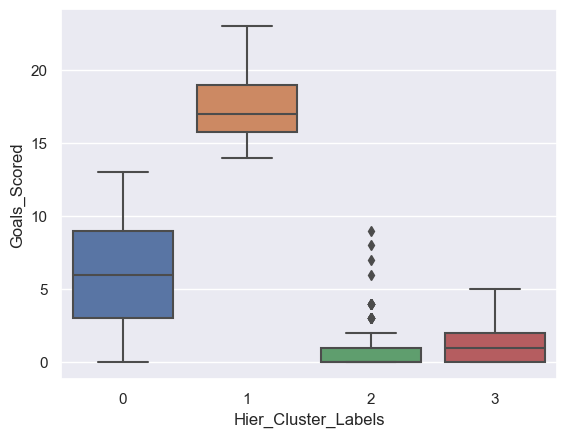

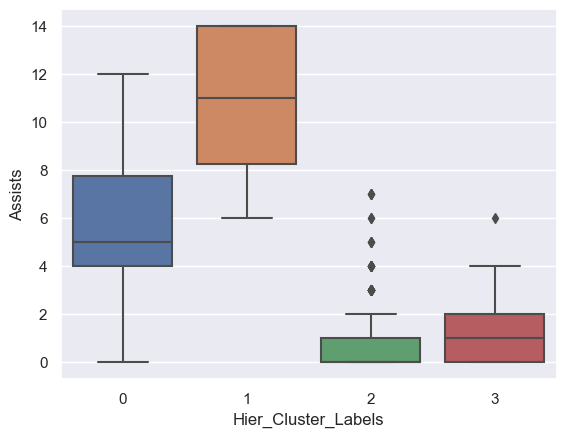

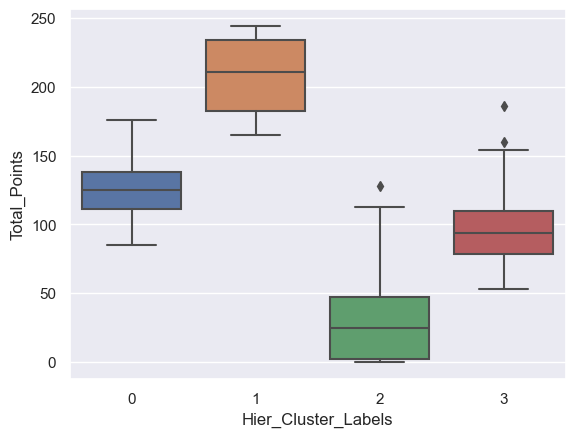

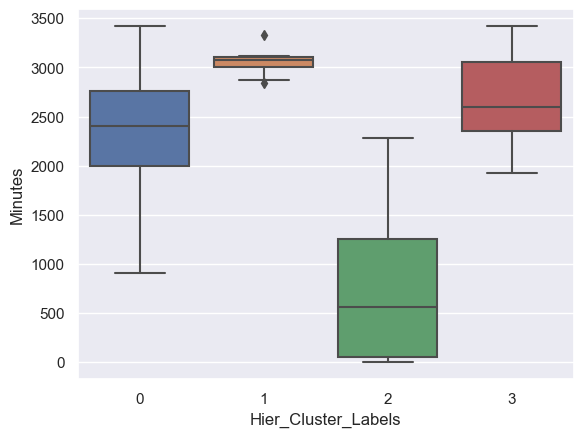

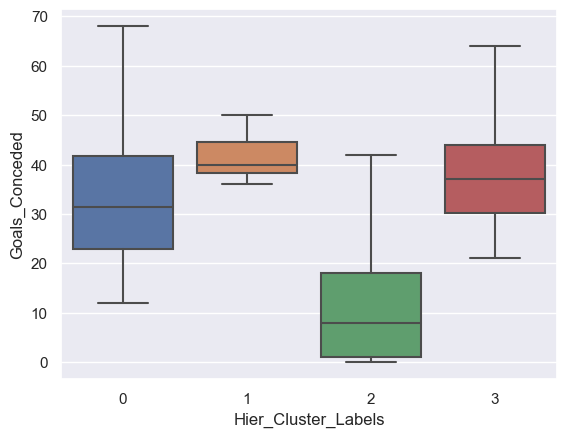

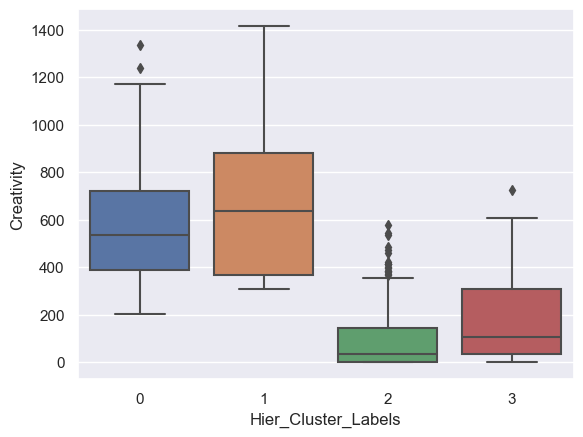

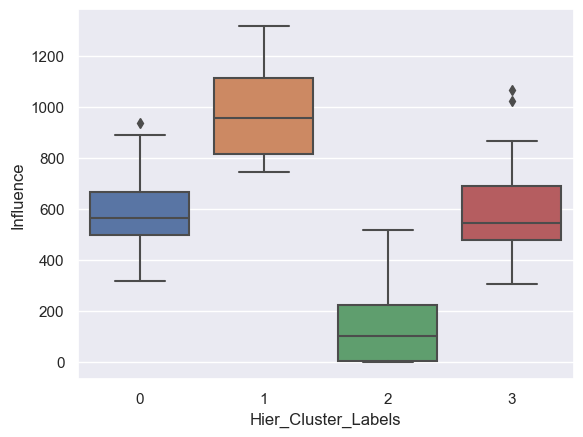

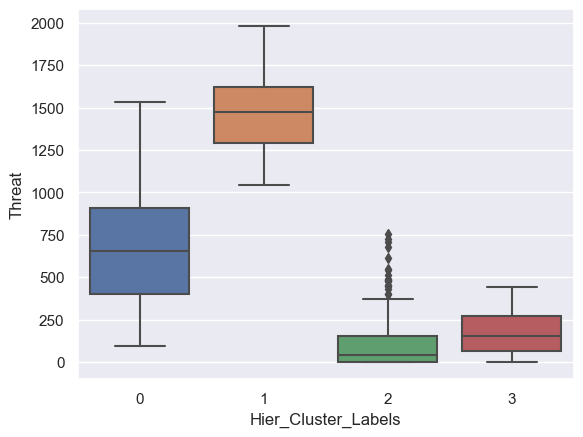

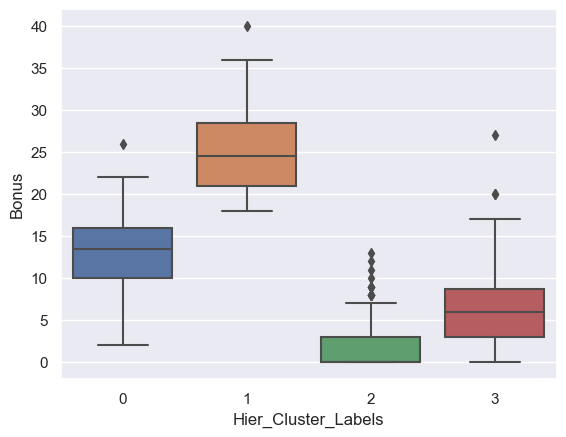

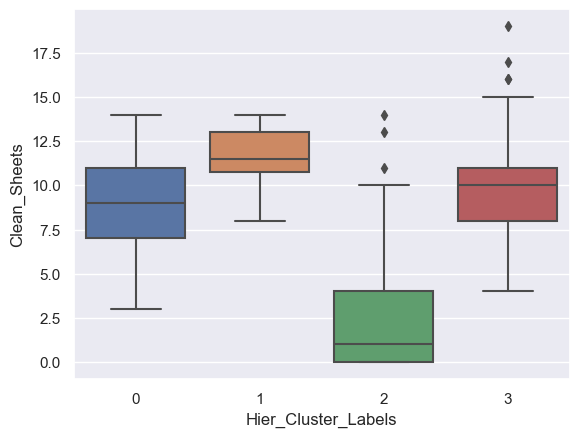

In [90]:
box_cols = ['Goals_Scored','Assists','Total_Points','Minutes','Goals_Conceded','Creativity','Influence','Threat','Bonus','Clean_Sheets']

for col in box_cols:
    sns.boxplot(x = 'Hier_Cluster_Labels', y = col, data = data)
    plt.show()

# DBSCAN

In [98]:
from sklearn.neighbors import NearestNeighbors

In [103]:
neighbors = NearestNeighbors(n_neighbors = 13)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

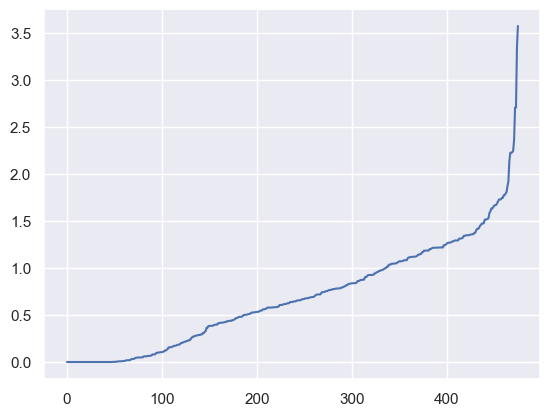

In [104]:
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

In [112]:
dbscan = DBSCAN(eps = 1.5)

scaled_data['DBSCAN_Labels'] = dbscan.fit_predict(scaled_data)
data['DBSCAN_Labels'] = dbscan.fit_predict(scaled_data)

In [113]:
data['DBSCAN_Labels'].value_counts()

 1    212
 0    146
-1     83
 2     22
 3     13
Name: DBSCAN_Labels, dtype: int64

In [114]:
dbscan = data.groupby('DBSCAN_Labels').mean()
dbscan['Players_in_Cluster'] = (data.groupby('DBSCAN_Labels')['Total_Points'].count().values)
dbscan

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,GMMLabels,Hier_Cluster_Labels,Players_in_Cluster
DBSCAN_Labels,,,,,,,,,,,,,,,
-1,5.891566,5.518072,128.168675,2485.445783,34.530120,547.381928,620.296386,620.867470,13.228916,9.445783,1.313253,0.433735,1.445783,0.746988,83
0,0.041096,0.000000,5.363014,148.821918,2.602740,9.612329,24.905479,11.506849,0.191781,0.321918,3.000000,3.000000,1.000000,2.000000,146
1,1.099057,1.287736,60.466981,1580.693396,23.150943,169.384906,318.621698,171.443396,3.754717,5.448113,0.877358,1.816038,0.000000,2.287736,212
2,7.772727,4.500000,116.590909,1938.000000,24.818182,434.940909,494.454545,721.045455,12.590909,7.409091,1.863636,0.000000,2.000000,0.000000,22
3,0.692308,0.307692,80.692308,2354.307692,32.230769,74.630769,514.723077,127.769231,3.615385,8.461538,0.846154,1.000000,0.000000,3.000000,13


In [120]:
dbscan.style.highlight_max(color = 'turquoise', axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Labels,KMed_Labels,GMMLabels,Hier_Cluster_Labels,Players_in_Cluster
DBSCAN_Labels,,,,,,,,,,,,,,,
-1,5.891566,5.518072,128.168675,2485.445783,34.530120,547.381928,620.296386,620.867470,13.228916,9.445783,1.313253,0.433735,1.445783,0.746988,83
0,0.041096,0.000000,5.363014,148.821918,2.602740,9.612329,24.905479,11.506849,0.191781,0.321918,3.000000,3.000000,1.000000,2.000000,146
1,1.099057,1.287736,60.466981,1580.693396,23.150943,169.384906,318.621698,171.443396,3.754717,5.448113,0.877358,1.816038,0.000000,2.287736,212
2,7.772727,4.500000,116.590909,1938.000000,24.818182,434.940909,494.454545,721.045455,12.590909,7.409091,1.863636,0.000000,2.000000,0.000000,22
3,0.692308,0.307692,80.692308,2354.307692,32.230769,74.630769,514.723077,127.769231,3.615385,8.461538,0.846154,1.000000,0.000000,3.000000,13


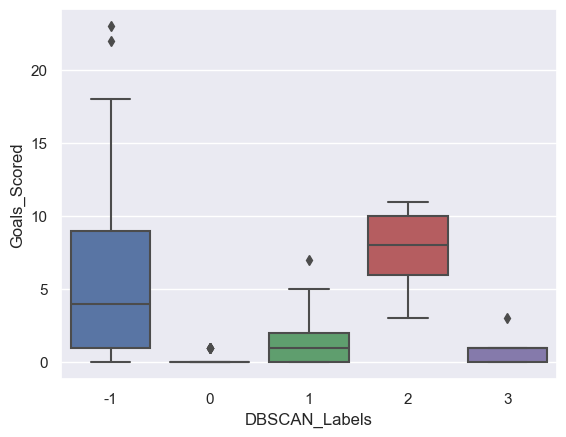

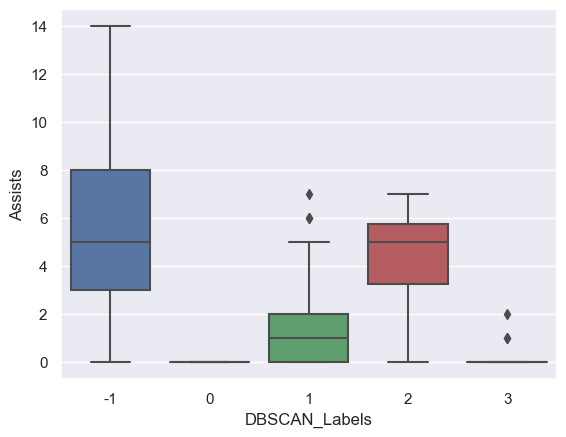

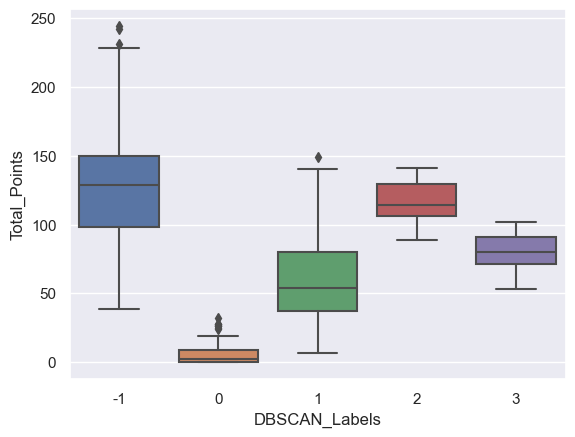

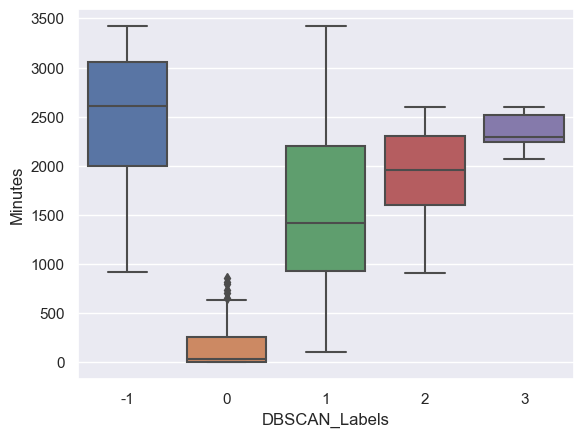

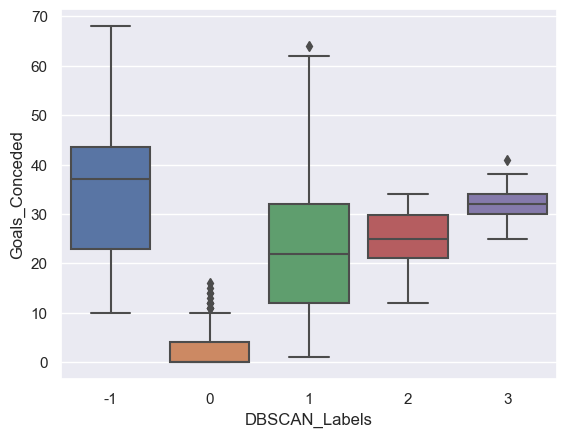

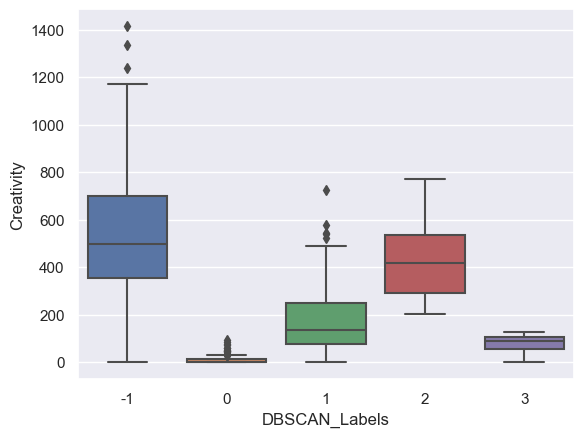

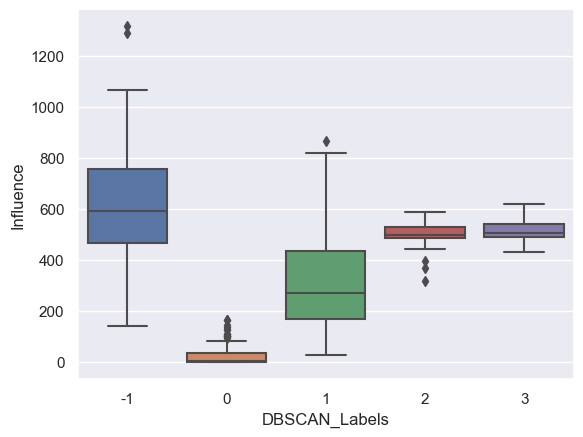

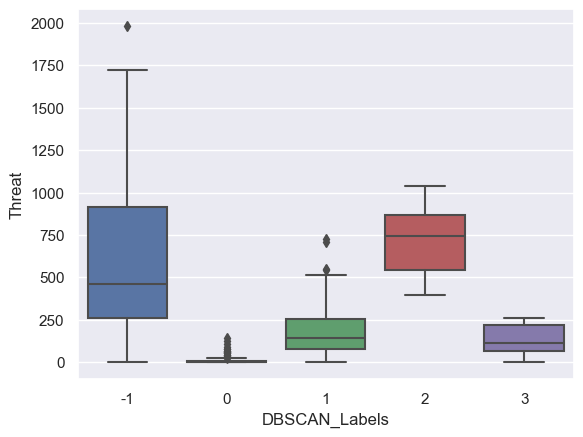

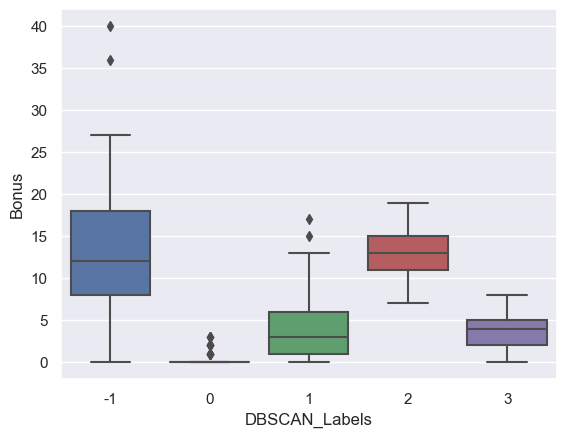

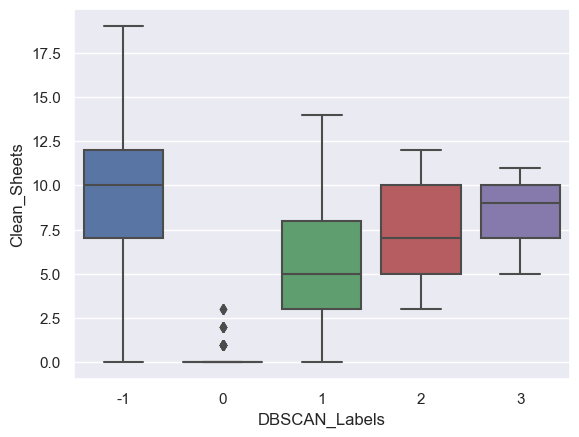

In [121]:
box_cols = ['Goals_Scored','Assists','Total_Points','Minutes','Goals_Conceded','Creativity','Influence','Threat','Bonus','Clean_Sheets']

for col in box_cols:
    sns.boxplot(x = 'DBSCAN_Labels', y = col, data = data)
    plt.show()

# Conclusion

**Original Objective:** Find clusters of players for fantasy sports pricing.
* K-Medoids seems to be the clusters with the closest numbers:
        - 3    171
        - 2    136
        - 1     87
        - 0     82
* Group 0 has the highest number of goals and assists followed by Groups 1 and 2 with very close numbers.
* Group 3 has almost no goals and no assists, save for the few outliers. 
* In terms of total points, group 0 has the...

# Recommendations

Include what each group would represent for the team. Group A = goal scorers, Group B = assisters, etc.

**Cluster 0**

**Cluster 1**

**Cluster 2**

**Cluster 3**
